<a href="https://colab.research.google.com/github/jawahirkhaleel/Jawahir/blob/main/_xee_water_deficit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade xee

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.1/472.1 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.5 MB/s eta 0:00:00
  Attempting uninstall: earthengine-api
    Found existing installation: earthengine-api 1.5.24
    Uninstalling earthengine-api-1.5.24:
      Successfully uninstalled earthengine-api-1.5.24


In [2]:
!pip install -U geemap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 68.9 MB/s eta 0:00:00
  Attempting uninstall: geemap
    Found existing installation: geemap 0.35.3
    Uninstalling geemap-0.35.3:
      Successfully uninstalled geemap-0.35.3


In [3]:
import ee

In [4]:
ee.Authenticate()
ee.Initialize(
    project = 'ee-jawahirkhaleel05',
    opt_url = 'https://earthengine-highvolume.googleapis.com'
)

In [5]:
import geemap

In [6]:
map = geemap.Map()
map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright', transp…

In [7]:
roi = map.draw_last_feature.geometry()
roi

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "Feature.geometry",
    "arguments": {
      "feature": {
        "functionInvocationValue": {
          "functionName": "Feature",
          "arguments": {
            "geometry": {
              "functionInvocationValue": {
                "functionName": "GeometryConstructors.Polygon",
                "arguments": {
                  "coordinates": {
                    "constantValue": [
                      [
                        [
                          66.269531,
                          23.966176
                        ],
                        [
                          66.269531,
                          38.61687
                        ],
                        [
                          77.519531,
                          38.61687
                        ],
                        [
                          77.519531,
                          23.966176
                        ],
                        [
                          66.269531,
                          23.966176
                        ]
                      ]
                    ]
                  },
                  "geodesic": {
                    "constantValue": false
                  }
                }
              }
            }
          }
        }
      }
    }
  }
})

In [8]:
mod = (
    ee.ImageCollection("MODIS/061/MOD16A2GF")
    .filterDate('2001','2025')
    .select('ET','PET')
    .map(
        lambda img: img.select('PET').subtract(img.select('ET')).multiply(0.1).rename('wd')
        .copyProperties(img, ['system:time_start'])
    )
)


In [9]:
mod

In [10]:
import xarray as xr

In [11]:
ds = xr.open_dataset(
    mod,
    engine = 'ee',
    crs = 'EPSG:4326',
    scale = 1,
    geometry = roi
)

In [12]:
ds = ds.sortby('time') * 1


In [13]:
import numpy as np


In [14]:
ds_annual = ds.resample(time = 'YE').sum('time')
ds_annual_mean = ds_annual.mean(dim = 'time')
ds_annual_mean = xr.where(ds_annual_mean == 0, np.nan, ds_annual_mean)

In [15]:
!pip install cartopy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 89.6 MB/s eta 0:00:00


In [16]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

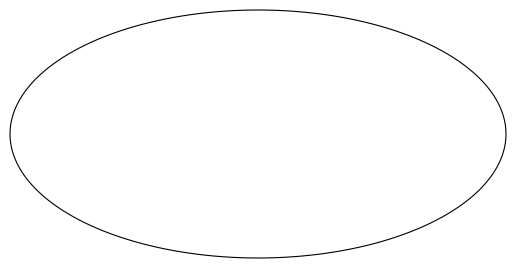

In [17]:
plt.figure()
ax = plt.axes(projection = ccrs.Hammer())


In [18]:
ax.coastlines(resolution = '110m')

In [20]:
ds_annual_mean.wd.plot.contourf(
    x = 'lon',
    y = 'lat',
    robust = 'True',
    levels = 10,
    alpha = 0.9,
    transform = ccrs.PlateCarree(),
    cmap = 'turbo',
    ax = ax,
    cbar_kwargs = {
        'orientation': 'horizontal',
        'pad': 0.05,
        'shrink': 0.7,
        'label': 'Water Deficit Index [mm]'
    }
)

In [21]:
plt.savefig('wd_map.png', dpi = 360, bbox_inches = 'tight')


<Figure size 640x480 with 0 Axes>

<xarray.Dataset> Size: 738kB
Dimensions:  (time: 1104, lon: 11, lat: 15)
Coordinates:
  * time     (time) datetime64[ns] 9kB 2001-01-01 2001-01-09 ... 2024-12-26
  * lon      (lon) float64 88B 66.77 67.77 68.77 69.77 ... 74.77 75.77 76.77
  * lat      (lat) float64 120B 24.47 25.47 26.47 27.47 ... 36.47 37.47 38.47
Data variables:
    wd       (time, lon, lat) float32 729kB nan 42.7 48.6 45.6 ... 2.7 6.2 4.6
Attributes:
    crs:      EPSG:4326

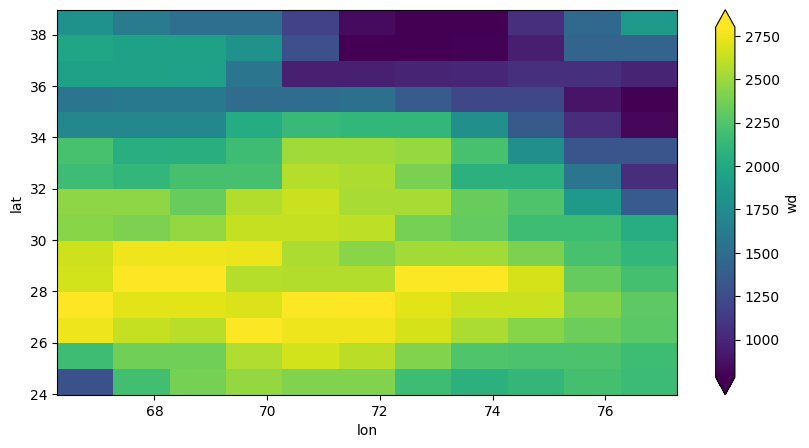

In [22]:
ds_annual_mean.wd.plot(
    x = 'lon',
    y = 'lat',
    robust = True,
    figsize = (10,5)
)

ds